In [4]:
from dataclasses import dataclass, field
from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional, Callable, cast
import copy
import uuid
from collections import defaultdict
from itertools import permutations
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm
import pickle
import bisect

# code-formatting
%load_ext nb_black


<IPython.core.display.Javascript object>

In [5]:
class Call:
    def __init__(self, threadno, func, args, start, end):
        super().__init__()
        self.threadno : int = threadno
        self.func : str = func
        self.args : List[Any] = args
        self.start : float = start
        self.end : float = end
        self.order : Optional[int] = None

    def __eq__(self, other : object):
        if not isinstance(other, Call):
            raise NotImplementedError
        return (self.threadno, self.func, self.args, self.start, self.end, self.order) == (other.threadno, other.func, other.args, other.start, other.end, other.order)

    def __hash__(self):
        return hash((self.threadno, self.func, tuple(self.args), self.start, self.end, self.order))
    
    def __str__(self):
        return f'{self.func}({self.args})'
    
    def exec(self, state : 'State') -> Tuple['State', Any]:
        raise NotImplementedError

class State:
    def copy(self) -> 'State':
        raise NotImplementedError
    

class History:
    """Nice wrapper for a list of calls"""
    def __init__(self, calls : List[Call]):
        self.calls : List[Call] = calls
    
    def __eq__(self, other : object):
        if not isinstance(other, History):
            raise NotImplementedError
        return self.calls == other.calls

@dataclass
class I:
    """
    If normal, start = first return, end = last call\n
    If reversed, start = last call, end = first return
    """
    start : float
    end : float
    reversed : bool = False
    

<IPython.core.display.Javascript object>

In [6]:
def sort_by_thread(spec: List[Call]):
    threads : DefaultDict[int, List[Call]] = defaultdict(list)
    for c in spec:
        threads[c.threadno].append(c)
    return threads

def visualize_history(spec : List[Call]):
    # make the graph big enough so that the labels don't overlap
    fig, ax = plt.subplots(figsize=(16, 10))
    threads = sort_by_thread(spec)

    ax.set_yticks(range(max(threads.keys()) + 2))
    # leave margins on the top and bottom of the graph for the labels
    ax.set_ylim(-0.5, max(threads.keys()) + 1.5)

    for threadno, ops in threads.items():
        for op in ops:
            # draw the interval
            ax.plot([op.start , op.end], [threadno, threadno], color='black')
            # add little ticks at the start and end of the interval
            ax.plot([op.start, op.start], [threadno - 0.1, threadno + 0.1], color='black')
            ax.plot([op.end, op.end], [threadno - 0.1, threadno + 0.1], color='black')
            # draw the label slightly above the interval
            ax.text((op.start + op.end) / 2, threadno + 0.1, str(op), horizontalalignment='center', verticalalignment='center')
            # draw the order of the operation above the label in red
            if op.order is not None:
                ax.text((op.start + op.end) / 2, threadno + 0.25, str(op.order), horizontalalignment='center', verticalalignment='center', color='red')
    
    plt.show()

<IPython.core.display.Javascript object>

In [7]:
def linearize_generic(spec: List[Call], state: State):
    threads: DefaultDict[int, List[Call]] = sort_by_thread(spec)

    def helper(threads: DefaultDict[int, List[Call]], state: State):
        res: List[List[Call]] = []
        first_op_per_thread = [t[0] for t in threads.values() if t]
        if not first_op_per_thread:
            return res
        ref = first_op_per_thread.pop()
        candidates: List[Call] = [ref]
        while first_op_per_thread:
            op = first_op_per_thread.pop()
            if op.start >= ref.end:
                # if op starts after ref ends, then we cannot call op before ref, as that would violate the linearizability
                continue
            elif op.end <= ref.end:
                ref = op
                candidates.append(op)
                # we have to recheck all exisiting candidates, as they might be invalidated by the new ref
                for c in tuple(candidates):
                    if c.start >= ref.end:
                        candidates.remove(c)
            else:
                # other 2 cases are when op starts before ref ends, and when op ends after ref ends
                candidates.append(op)

        # now we just pop a candidate an proceed by recursion
        # print(f'candidates: {candidates}')
        for c in candidates:
            # print(f'candidate: {c}')

            new_state = state.copy()
            optional_state = c.exec(new_state)
            if optional_state is not None:
                new_state, _ = optional_state
            else:
                continue

            threads_copy = copy.deepcopy(threads)

            threads_copy[c.threadno].pop(0)
            sol = helper(threads_copy, new_state)
            if sol is not None:
                # since sol is a list of solutions, we need to add the current candidate to all of them
                # two cases:
                # 1. sol is empty, then we just add the candidate
                # 2. sol is not empty, then we add the candidate to all of them
                if sol == []:
                    res.append([c])
                else:
                    for s in sol:
                        s.insert(0, c)
                    res.extend(sol)

        if not res:
            return None
        return res

    # sort threads by the start time of the first operation
    for t in threads.values():
        t.sort(key=lambda x: x.start)
    ret = helper(threads, state)
    if ret is None:
        return ret
    for i in range(len(ret)):
        for j in range(len(ret[i])):
            ret[i][j].order = j + 1

    return ret


<IPython.core.display.Javascript object>

In [8]:
# These are special cases for the queue example

@dataclass
class StateQueue(State):
    stack : List[Any] = field(default_factory = list)

    def copy(self):
        return StateQueue(stack=self.stack.copy())


class CallEnq(Call):
    def __init__(self, threadno, arg : int, start, end):
        self.arg = arg
        super().__init__(threadno, "enq", [arg], start, end)

    def exec(self, state):
        if not isinstance(state, StateQueue):
            raise Exception("State is not a StateQueue")
        state.stack.append(self.arg)
        return state, None

class CallDeq(Call):
    def __init__(self, threadno, arg : int, start, end):
        self.arg = arg
        super().__init__(threadno, "deq", [arg], start, end)

    def exec(self, state):
        if not isinstance(state, StateQueue):
            raise Exception("State is not a StateQueue")
        if len(state.stack) == 0:
            return 
        e = state.stack.pop(0)
        if e != self.arg:
            return 
        return state, e

<IPython.core.display.Javascript object>

In [9]:
# These are special cases for the i/o operations on the register example

@dataclass
class StateIO(State):
    value : Optional[int] = None

    def copy(self):
        return StateIO(value=self.value)

class CallWrite(Call):
    def __init__(self, threadno, arg : int, start, end):
        self.arg = arg
        super().__init__(threadno, "write", [arg], start, end)

    def exec(self, state):
        if not isinstance(state, StateIO):
            raise Exception("State is not of type StateIO")
        state.value = self.arg
        return state, None

class CallRead(Call):
    def __init__(self, threadno, arg : int, start, end):
        self.arg = arg
        super().__init__(threadno, "read", [arg], start, end)

    def exec(self, state):
        if not isinstance(state, StateIO):
            raise Exception("State is not of type StateIO")
        if state.value is None:
            return
        if state.value != self.arg:
            return
        return state, None
    
class CallCAS(Call):
    def __init__(self, threadno, compare: int, swap: int, cond: bool, start, end):
        self.cond = cond
        self.compare = compare
        self.swap = swap
        super().__init__(threadno, f"cas", [compare, swap, cond], start, end)
    
    def __str__(self):
        if self.cond:
            return f"{self.compare} -> {self.swap}"
        else:
            return f"!{self.compare}"
        
    def exec(self, state):
        if not isinstance(state, StateIO):
            raise Exception("State is not of type StateIO")
        if state.value is None:
            return
       # if cond is True, the value must be equal to compare
        if self.cond:
            if state.value != self.compare:
                return
            state.value = self.swap
            return state, None
        # if cond is False, the value must be different from compare
        else:
            if state.value == self.compare:
                return
            return state, None

<IPython.core.display.Javascript object>

In [29]:
def linearize_io(spec: List[Call]):
    sort_by_var: DefaultDict[int, List[Call]] = defaultdict(list)
    false_cases: List[CallCAS] = []
    true_cases: List[CallCAS] = []
    for c in spec:
        if isinstance(c, (CallWrite, CallRead)):
            sort_by_var[c.arg].append(c)
        elif isinstance(c, CallCAS) and c.cond:
            sort_by_var[c.swap].append(c)
            sort_by_var[c.compare].append(c)
            true_cases.append(c)
        elif isinstance(c, CallCAS) and not c.cond:
            false_cases.append(c)

    # basic checks
    writes: Dict[int, CallWrite | CallCAS] = {}
    for var, var_class in sort_by_var.items():
        # check that there is exactly one write for each variable
        # (both write and cas can write)
        if sum([isinstance(c, CallWrite) or (isinstance(c, CallCAS) and c.cond and c.swap == var) for c in var_class]) != 1:
            return
           
        # check that the the first read doesn't end before the write starts
        write = next(c for _, c in enumerate(var_class) if isinstance(c, CallWrite)
                     or (isinstance(c, CallCAS) and c.cond and c.swap == var))
        writes[var] = write

        if not all(read.end > write.start for read in var_class if not (isinstance(read, CallWrite) or (isinstance(read, CallCAS) and read.cond and read.swap == var))):
            return
        

    # make intervals from first return of any operation (read or write) to the last call of any operation (read or write
    intervals: Dict[int, I] = {}
    for var, var_class in sort_by_var.items():
        i1 = min(c.end for c in var_class)
        i2 = max(c.start for c in var_class)
        if i1 < i2:
            # No write/read happens in the interval
            intervals[var] = I(i1, i2)
        else:
            intervals[var] = I(i2, i1, True)

    # check that there are no loops, ex 1 -> 2, 2 -> 1

    from linearize_io_helper import has_loop
    if has_loop(true_cases):
        return

     # In a linearized history, operations on the same variable happen in a row. So we need to understand the order between variables. We can do this by pairing them in blocks, where variables in the same block mean that without cas, the variables can be linearized in any order.

    # blocks = get_io_blocks(spec)
    graph: DefaultDict[int, List[int]] = defaultdict(list)

    for var_i, interval_i in intervals.items():
        i1, i2 = interval_i.start, interval_i.end
        for var_j, interval_j in intervals.items():
            j1, j2 = interval_j.start, interval_j.end
            if not interval_i.reversed and not interval_j.reversed:
                continue
            elif not interval_i.reversed:
                if j1 < i1 and j2 > i2:
                    graph[var_i].append(var_j)
            elif not interval_j.reversed:
                if i1 < j1 and i2 > j2:
                    graph[var_i].append(var_j)
            else:
                if i1 < j2 < i2 or j1 < i2 < j2:
                    graph[var_i].append(var_j)

    for key in sort_by_var:
        bisect.insort(graph[key], key)

    blocks: List[List[int]] = []
    for block in graph.values():
        if block not in blocks:
            blocks.append(block)

    blocks.sort(key=lambda x: max(intervals[v].start for v in x))



    for var, var_class in sort_by_var.items():
        same_var_interval = intervals[var]
        last_call = same_var_interval.start if same_var_interval.reversed else same_var_interval.end
        first_return = same_var_interval.end if same_var_interval.reversed else same_var_interval.start
        for i_var, interval in intervals.items():
            if i_var == var or interval.reversed:
                continue
            # observation 1
            if first_return <= interval.end and last_call >= interval.start:
                return 
            # observation 2
            if last_call >= interval.start and first_return <= interval.end:
                return

   
    available_writes: Set[CallWrite | CallCAS] = set()
    block_i = 0
    captured_write = None
    false_cases.sort(key=lambda x: x.start)

    for false_cas in false_cases:
        while block_i < len(blocks):

            # 1. clear the available_writes if we are in a new block
            # 2. add the writes from the current block that started before the false cas return 
            # 3. we advance to the next block if false cas start is after the last write in the current block

            block = blocks[block_i]
            writes_in_block = {writes[var] for var in block if writes[var].start < false_cas.end}

            if min((min(c.end for c in sort_by_var[var]) for var in block)) < false_cas.start:
                available_writes.clear()
                captured_write = None
           
            available_writes.update(writes_in_block)
                
            if len(writes_in_block) == 0:
                block_i -= 1
                break
            elif len(writes_in_block) == len(block):
                block_i += 1
            else:
                break

        if false_cas.compare in writes:
            captured_write = writes[false_cas.compare]
            available_writes.discard(captured_write)

        if not available_writes:
            return false_cas.compare

        cas_interval: Optional[I] = intervals.get(false_cas.compare)
        if cas_interval and not cas_interval.reversed:
            flag = False

            if false_cas.end > cas_interval.end:
                for w in available_writes:
                    if w.end > cas_interval.end:
                        flag = True

            if false_cas.start < cas_interval.start:
                for w in available_writes:
                    if w.start < cas_interval.start:
                        flag = True

            if not flag:
                return false_cas.compare

        else:
            latest_diff_w_ret = max(_w.end for _w in available_writes)

            if cas_interval is not None:
                i1, i2 = cas_interval.start, cas_interval.end
            else:
                i1 = i2 = 0
            
            if false_cas.start > i2 and latest_diff_w_ret < i1:
                return false_cas.compare
            
        if captured_write is not None and min(c.end for c in sort_by_var[captured_write.args[0]]) > false_cas.start:
            available_writes.add(captured_write)

        captured_write = None
    # if we get here, then the history is linearizable.

    return True


<IPython.core.display.Javascript object>

In [11]:
def generate_random_spec(n : int, m : int, p : int):
    """
    n is the number of threads\n
    m is the number of operations\n
    p is the number of variables\n
    the only constraint is that operations cannot overlap in time on the same thread
    """
    
    ops = ["io"]
    var_dict : DefaultDict[Any, bool] = defaultdict(lambda: False)

    threads : DefaultDict[int, List[Call]] = defaultdict(list)
    for _ in range(m):
        thread = random.randint(1, n)
        op = random.choice(ops)
        start: float
        end: float
        if len(threads[thread]) == 0:
            start = 0
        else:
            start = threads[thread][-1].end 

        start += random.randint(0, 5) + random.random()
        end = start + random.randint(1, 10) + random.random()
        arg = random.randint(0, p)
        arg2 = arg
        if op == "cas":
            while arg == arg2:
                arg2 = random.randint(0, p)
        if op == "io" and var_dict[arg]:
            threads[thread].append(
                CallRead(
                    threadno=thread, 
                    arg=arg,
                    start=start,
                    end=end))
        elif op == "io" and not var_dict[arg]:
            var_dict[arg] = True
            threads[thread].append(
                CallWrite(
                    threadno=thread, 
                    arg=arg,
                    start=start,
                    end=end))
        elif op == "cas" and var_dict[arg]:
            continue
            threads[thread].append(
                CallCAS(
                    threadno=thread,
                    compare=arg2,
                    swap=arg,
                    cond=False,
                    start=start,
                    end=end))
        elif op == "cas" and not var_dict[arg] and not var_dict[arg2]:
            var_dict[arg] = True
            var_dict[arg2] = True
            threads[thread].append(
                CallCAS(
                    threadno=thread,
                    compare=arg2,
                    swap=arg,
                    cond=True,
                    start=start,
                    end=end))
        else:
            raise NotImplementedError(f"Operation {op} not implemented")
    return [c for thread in threads.values() for c in thread]

<IPython.core.display.Javascript object>

In [12]:
# generate_random_spec(3, 7, 5, [CallWrite, CallRead, CallCAS])
# only 1.22% of examples are linearizable, so lets create our own

# get the % of linearizable examples

# n = 10000
# successful = 0
# for i in range(n):
#     spec = generate_random_spec(3, 7, 5, [CallWrite, CallRead, CallCAS])
#     if linearize_generic(spec, StateIO()):
#         successful += 1

# print(f"{successful/n*100}% of examples are linearizable")

# filename = "testio.pkl"
# total = 5000
# success_percentage = 0.5
# success = []
# fail = []
# loading = tqdm(total=total)
# while loading.n < loading.total:
#     spec = generate_random_spec(3,8,4)
#     # if there is not at least 2 cas operations, then we can't test the false case
#     # if len([c for c in spec if isinstance(c, CallCAS)]) < 1:
#     #     continue
#     if len([c for c in spec if isinstance(c, CallRead)]) < 3:
#         continue
#     if len(spec) < 8:
#         continue
#     sol = linearize_generic(spec, StateIO())
#     if sol is None and len(fail) < total * (1 - success_percentage):
#         fail.append(spec)
#         loading.update()
#     elif sol is not None and len(success) < total * success_percentage:
#         success.append(spec)
#         loading.update()

# with open(filename, "wb") as f:
#     for spec in success:
#         pickle.dump((spec, True), f)
#     for spec in fail:
#         pickle.dump((spec, False), f)

<IPython.core.display.Javascript object>

In [13]:
# 5k 50/50
with open("testio.pkl", "rb") as f:
    TESTIO = []
    while True:
        try:
            TESTIO.append(pickle.load(f))
        except EOFError:
            break

# with open("testio10k.pkl", "rb") as f:
#     TESTIO10K = []
#     while True:
#         try:
#             TESTIO10K.append(pickle.load(f))
#         except EOFError:
#             break

# 5k 50/50
with open("testcastrue.pkl", "rb") as f:
    TESTCASTRUE = []
    while True:
        try:
            TESTCASTRUE.append(pickle.load(f))
        except EOFError:
            break

# 50k 10/90
with open("testcasfalse.pkl", "rb") as f:
    TESTCASFALSE = []
    while True:
        try:
            TESTCASFALSE.append(pickle.load(f))
        except EOFError:
            break

# with open("testcas1k.pkl", "rb") as f:
#     TESTCAS1K = []
#     while True:
#         try:
#             TESTCAS1K.append(pickle.load(f))
#         except EOFError:
#             break

<IPython.core.display.Javascript object>

In [31]:
# 200 hps
# for i in tqdm(range(len(testcas))):
#     spec = testcas[i]
#     try:
#         sol = linearize_generic(spec, StateIO()) 
#         if sol is None:
#             assert linearize_io(spec) is None, f"Test {i}: Solution {sol} is not None"
#         else:
#             assert linearize_io(spec) in sol, f"Test {i}: Solution {sol} does not contain {linearize_io(spec)}"
            
#     except AssertionError as e:
#        if not ("more than one write" in str(e) or \
#                "no reads" in str(e) or \
#                 "HACK" in str(e)):
#             raise e

# 100k+ hps
testsample = TESTCASTRUE
wrong_test_no = []
for i in tqdm(range(len(testsample))):
    testcase, res = copy.deepcopy(testsample[i])
    try:
        sol = linearize_io(testcase)
        s2 = (sol is True)
        if res ^ s2:
            wrong_test_no.append(i)
             
    except AssertionError as e:
            raise e

print(f"Tests failed: {len(wrong_test_no)}")
if len(wrong_test_no) == 0:
    print("All tests passed")
else:
    print(f"First failed: {wrong_test_no}")


100%|██████████| 5000/5000 [00:00<00:00, 9997.80it/s] 


Tests failed: 12
First failed: [2959, 3706, 3835, 3988, 4160, 4387, 4507, 4568, 4647, 4674, 4709, 4768]


<IPython.core.display.Javascript object>

Testcase 2959 is False
True


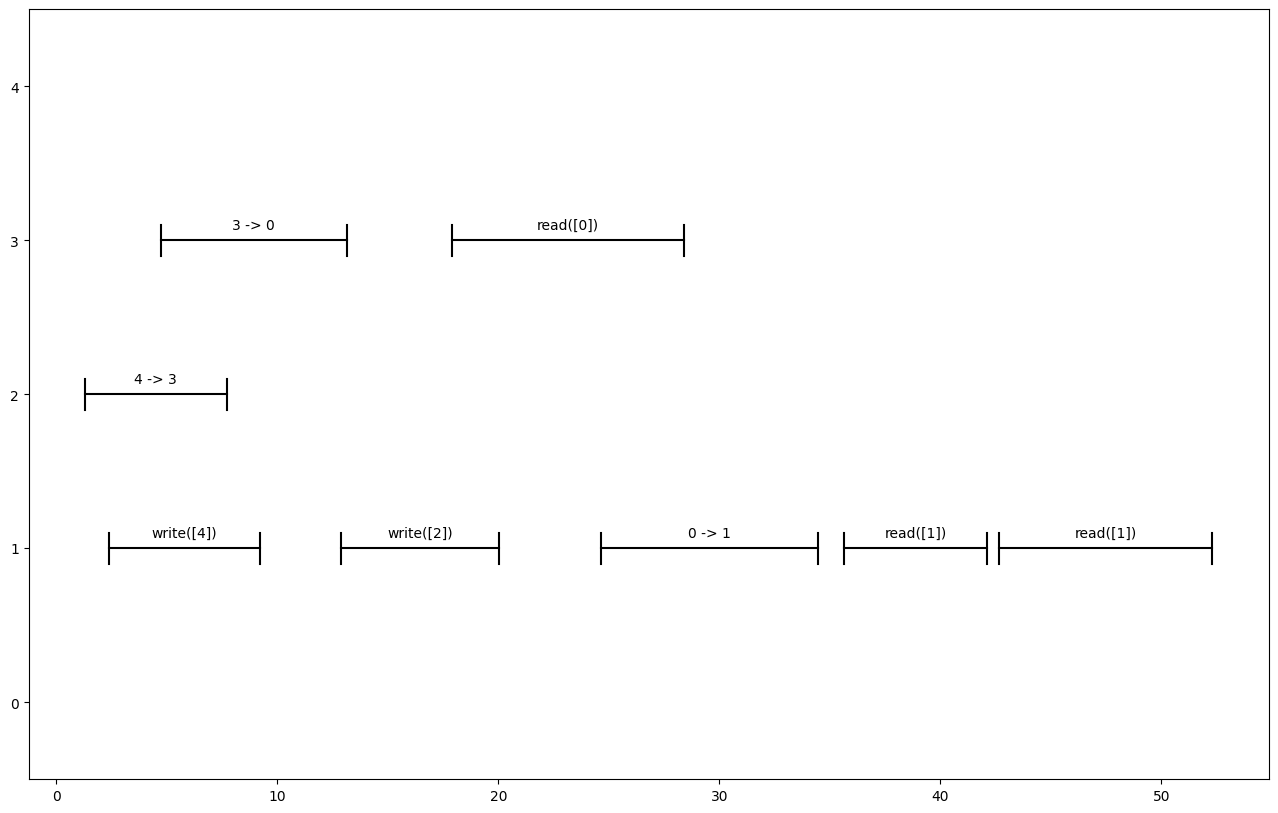

<IPython.core.display.Javascript object>

In [32]:
i = 2959
testcase, res = copy.deepcopy(testsample[i])
print(f"Testcase {i} is {res}")
print(linearize_io(testcase))
visualize_history(testcase)



In [33]:
if len(wrong_test_no) < 10:
    for wrong_test in wrong_test_no:
        testcase, res = copy.deepcopy(testsample[wrong_test])
        print(f"Testcase {wrong_test} is {res}")
        print(linearize_io(testcase))
        visualize_history(testcase)

<IPython.core.display.Javascript object>

True


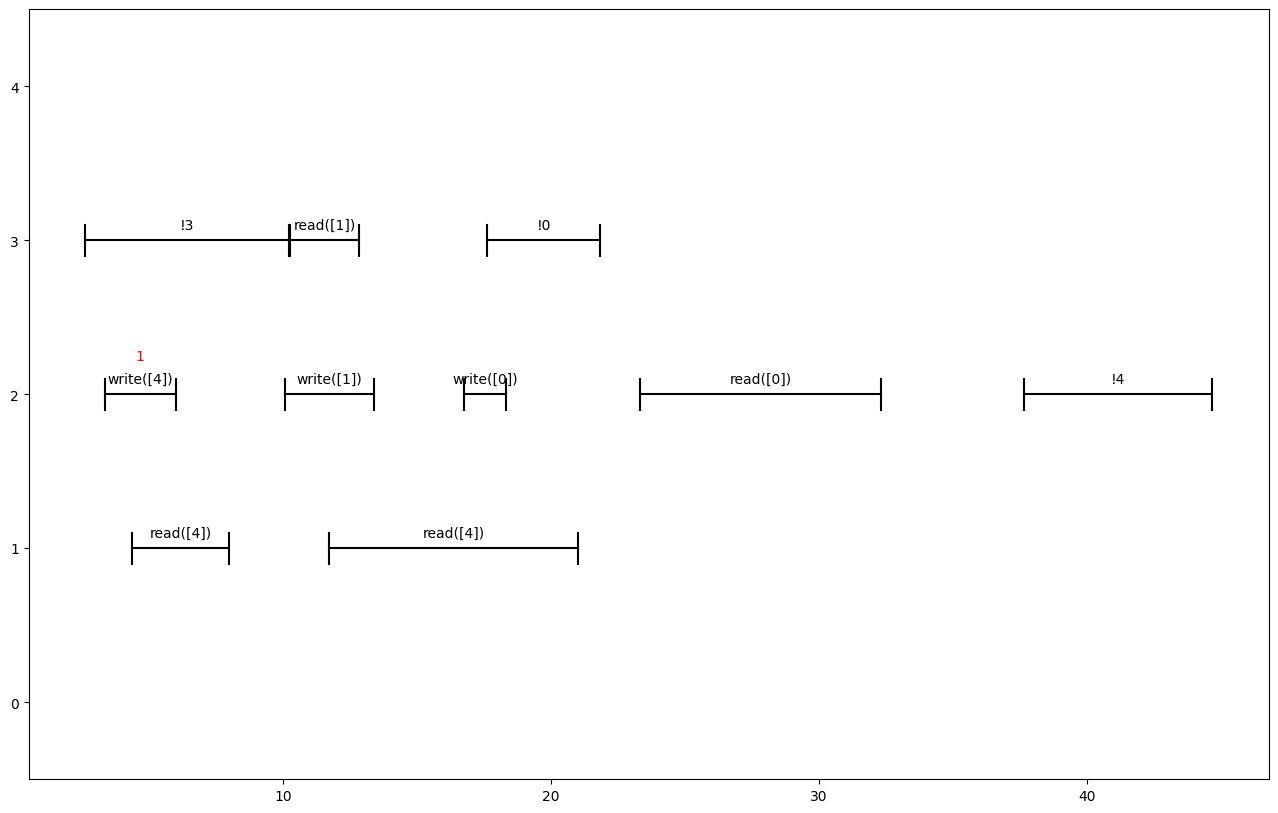

<IPython.core.display.Javascript object>

In [ ]:
testcase, res = copy.deepcopy(testsample[i])

print(linearize_io(testcase))
visualize_history(testcase)
